In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/cleaned_tweets (3).csv')
data = data.dropna(subset=['final_text', 'airline_sentiment', 'airline'])
data['final_text'] = data['final_text'].astype(str)
data['label'] = data['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})


In [ ]:
negative_tweets = data[data['label'] == 0].copy()


In [ ]:
crisis_keywords = [
    'delay', 'delayed', 'cancel', 'canceled', 'cancelled', 'lost luggage', 'baggage',
    'disaster', 'emergency', 'horrible', 'terrible', 'worst', 'nightmare', 'disgusting',
    'stranded', 'stuck', 'missed flight', 'overbooked', 'rude staff', 'unprofessional',
    'unsafe', 'dangerous', 'scared', 'panic', 'emergency landing'
]

In [ ]:
def enhanced_crisis_detection(tweet):
    tweet_lower = tweet.lower()
    keyword_count = sum(1 for keyword in crisis_keywords if keyword in tweet_lower)
    return 1 if keyword_count > 0 else 0

negative_tweets['is_crisis'] = negative_tweets['final_text'].apply(enhanced_crisis_detection)


In [ ]:
def extract_features(tweets):
    features = pd.DataFrame()
    features['text_length'] = tweets.str.len()
    features['word_count'] = tweets.str.split().str.len()
    features['exclamation_count'] = tweets.str.count('!')
    features['question_count'] = tweets.str.count('\?')
    features['caps_ratio'] = tweets.apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
    return features

In [ ]:

X_text = negative_tweets['final_text']
X_features = extract_features(X_text)
y = negative_tweets['is_crisis']

# Split data
X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_text, X_features, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:

# TF-IDF
tfidf = TfidfVectorizer(
    max_features=2000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

In [ ]:
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

# Combine features
X_train_combined = hstack([X_text_train_tfidf, X_feat_train.values])
X_test_combined = hstack([X_text_test_tfidf, X_feat_test.values])


In [ ]:

# Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)


In [ ]:

# Cross-Validation
cv_scores = cross_val_score(rf_model, X_train_combined, y_train, cv=5, scoring='f1')
print(f"Random Forest Cross-Validation F1 Scores: {cv_scores}")
print(f"Average RF CV F1 Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


Random Forest Cross-Validation F1 Scores: [0.8403526  0.8659595  0.85050505 0.85544554 0.86502463]
Average RF CV F1 Score: 0.855 (+/- 0.019)


In [ ]:
rf_model.fit(X_train_combined, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:

# Predict
y_pred = rf_model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nRandom Forest Test Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Crisis', 'Crisis']))



Random Forest Test Accuracy: 0.905

Classification Report:
              precision    recall  f1-score   support

  Non-Crisis       0.90      0.96      0.93      1187
      Crisis       0.91      0.81      0.86       649

    accuracy                           0.90      1836
   macro avg       0.91      0.88      0.89      1836
weighted avg       0.91      0.90      0.90      1836



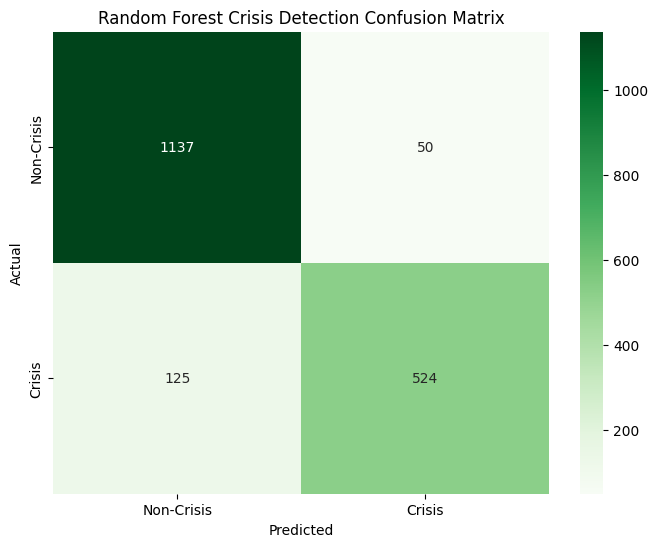

In [ ]:

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Crisis', 'Crisis'],
            yticklabels=['Non-Crisis', 'Crisis'])
plt.title('Random Forest Crisis Detection Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


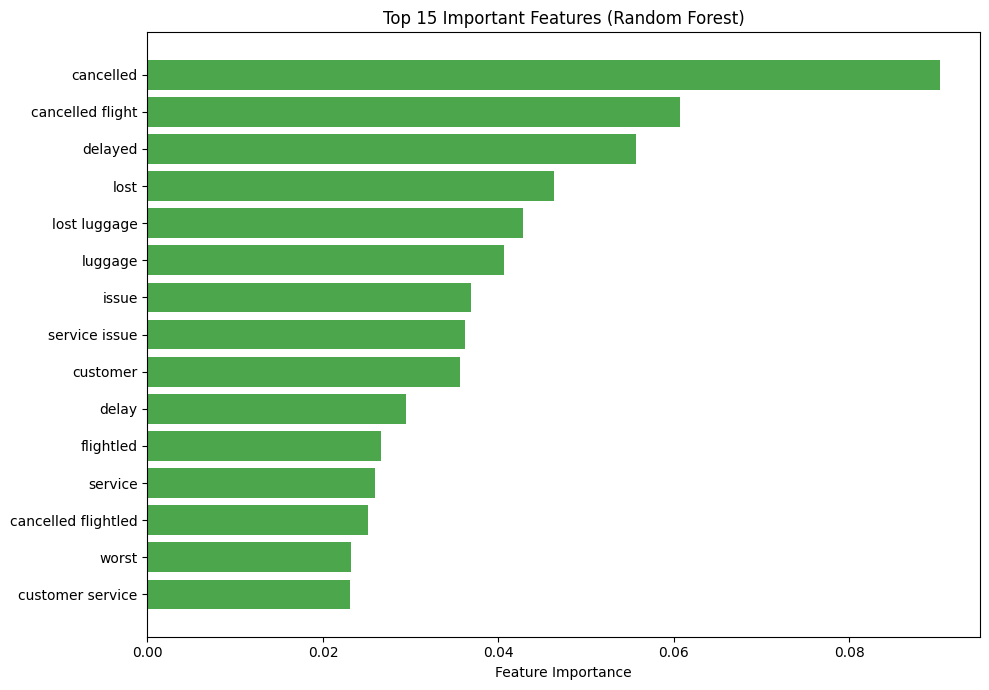

In [ ]:

# Feature Importance (top 15)
importances = rf_model.feature_importances_
feature_names = list(tfidf.get_feature_names_out()) + list(X_features.columns)
indices = importances.argsort()[-15:]
plt.figure(figsize=(10, 7))
plt.barh(range(len(indices)), importances[indices], color='green', alpha=0.7)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 15 Important Features (Random Forest)')
plt.tight_layout()
plt.show()